In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib
import os

# Tests for the xAI-2024 conference paper
# Load datasets

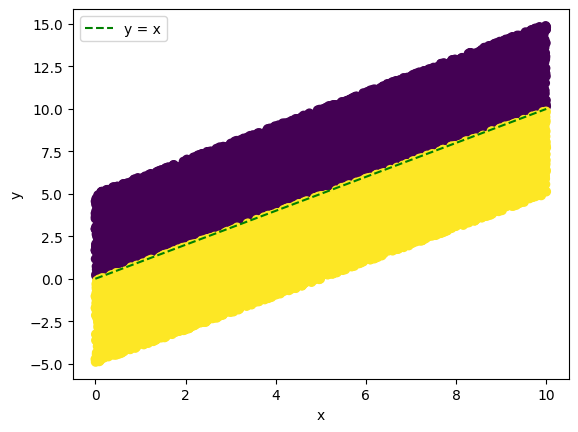

          x         y  output
0  3.274476  5.411284       0
1  7.184664  9.508939       0
2  1.860253  5.387685       0
3  1.194554  4.859849       0
4  8.902297  9.704339       0
Split Done


In [2]:
data_path = "simulationVictorTopological/"
datafilename = "dataset.csv"

# Número de puntos
num_points = 10000

# Generar puntos arriba de la diagonal (y > x)
x_above = np.random.uniform(0, 10, num_points)
y_above = x_above + np.random.uniform(0.1, 5, num_points)
category_above = np.full(num_points, 0)

# Generar puntos debajo de la diagonal (y < x)
x_below = np.random.uniform(0, 10, num_points)
y_below = x_below - np.random.uniform(0.1, 5, num_points)
category_below = np.full(num_points, 1)

# Combinar los puntos y las categorías en un DataFrame
x = np.concatenate((x_above, x_below))
y = np.concatenate((y_above, y_below))
category = np.concatenate((category_above, category_below))

# Visualización
plt.scatter(x, y, c=category)
plt.plot([0, 10], [0, 10], color="green", linestyle="--", label="y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

data = pd.DataFrame({
    'x': x,
    'y': y,
    'output': category
})

# Mostrar las primeras filas del dataset
print(data.head())

RESULTS_FILE = 'simulationVictorTopological/dataset.csv'
data.to_csv(RESULTS_FILE,index = False)

# Verifica si el archivo existe en la carpeta
if os.path.exists(os.path.join(data_path, "train.csv")):
    print("Train.csv exists")
else:
    data = pd.read_csv(data_path+datafilename)
    n_tr = 4000
    n_ts = 1000
    n_c = 5000
    split_dataset(data.drop(["output"],axis = 1).values,data.iloc[:,2].values,n_tr,n_ts,n_c,save_path=data_path)

In [3]:
datapath = "simulationVictorTopological/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [4]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,x,y,output
0,6.612276,7.547639,0
1,5.398311,5.185616,1
2,9.136737,8.288656,1
3,9.698311,9.056618,1
4,3.010637,-1.255817,1
...,...,...,...
3995,6.005603,8.703701,0
3996,3.364556,6.122650,0
3997,2.055352,-0.721592,1
3998,6.012878,7.038134,0


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [6]:
Xtr = dbtrain[["x","y"]].values
Ytr = dbtrain[['output']].values
Ytr[Ytr>=1] = 1
Ytr[Ytr==0] = -1

Xts = dbtest[["x","y"]].values
Yts = dbtest[['output']].values
Yts[Yts>=1] = 1
Yts[Yts==0] = -1

Xcal = dbcal[["x","y"]].values
Ycal = dbcal[['output']].values
Ycal[Ycal>=1] = 1
Ycal[Ycal==0] = -1

# Exploratory analisis

In [7]:
correlation_matrix = dbtrain.corr()
print(correlation_matrix)

dbtrain['outputTrans'] = dbtrain['output'].apply(lambda x: 1 if x > 0 else -1)
dbtrain

               x         y    output
x       1.000000  0.703885  0.011335
y       0.703885  1.000000 -0.611452
output  0.011335 -0.611452  1.000000


,x,y,output,outputTrans
0,6.612276,7.547639,0,-1
1,5.398311,5.185616,1,1
2,9.136737,8.288656,1,1
3,9.698311,9.056618,1,1
4,3.010637,-1.255817,1,1
...,...,...,...,...
3995,6.005603,8.703701,0,-1
3996,3.364556,6.122650,0,-1
3997,2.055352,-0.721592,1,1
3998,6.012878,7.038134,0,-1


## Dispersion plots

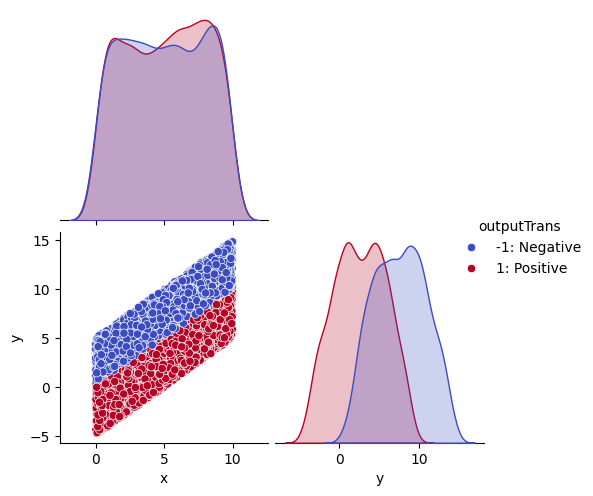

In [10]:
pairplot = sns.pairplot(dbtrain, vars=["x","y"], hue='outputTrans', palette='coolwarm',corner=True)
new_labels = ['-1: Negative', '1: Positive']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

## Boxplots

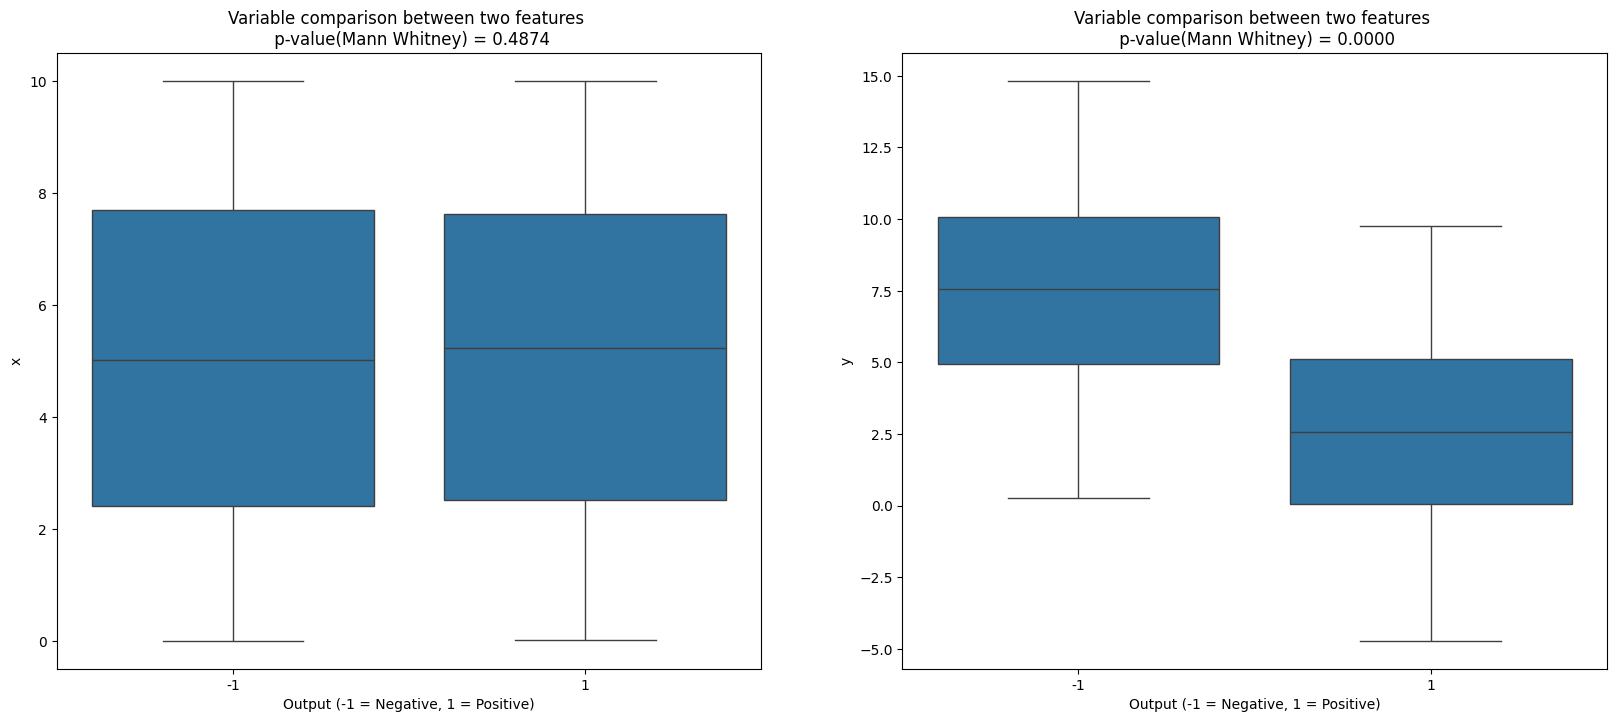

In [12]:
from scipy.stats import mannwhitneyu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(['x','y']):
    Cvalues = dbtrain[dbtrain["outputTrans"] == 1][i].values
    NCvalues = dbtrain[dbtrain["outputTrans"] == -1][i].values
    u_stat, p_value = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='outputTrans', y=i, data=dbtrain)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value:.4f}')
    plt.xlabel("Output (-1 = Negative, 1 = Positive)")
    plt.ylabel(i)

plt.show()

# SVM parameters setting

In [13]:
# Parameters settings
kernel = "gaussian" #with gaussian work, with polynomial no.
param = 0.5 # play with this to improve model evaluation, explaination on chatgpt
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [14]:
epsilon = 0.1

## 1) Classic SVM

In [15]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr,Ytr) # solo caract topol
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 145.50286436080933 seconds


In [16]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([ 1.53751795e-05,  5.00012163e-01,  4.70027443e-06, ...,
         2.44375993e-02, -1.61108163e-06,  8.18330832e-03]),
 'b': array([-0.00040652]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

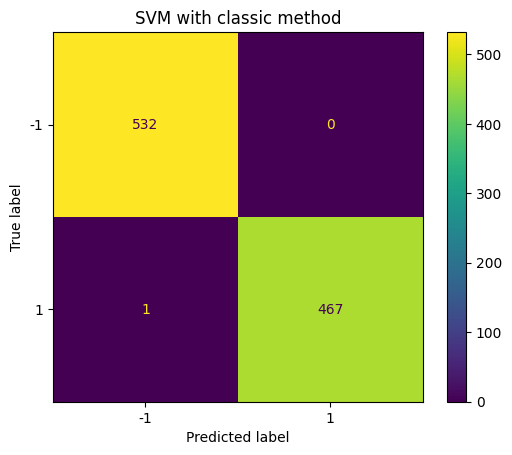

ACC = 0.999, F1 = 0.9989304812834224, PPV = 1.0, NPV = 0.99812382739212, TPR = 0.9978632478632479, TNR = 1.0, FPR = 0.0, FNR = 0.002136752136752137

TP = 467, FP = 0, TN = 532, FN = 1


In [17]:
metricsClassic = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")


In [18]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictorTopological/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [19]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'ps')
model.get_params()

{'alpha': array([ 1.53751795e-05,  5.00012163e-01,  4.70027443e-06, ...,
         2.44375993e-02, -1.61108163e-06,  8.18330832e-03]),
 'b': array([-0.00040652]),
 'b_eps': -0.9622658233374131,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

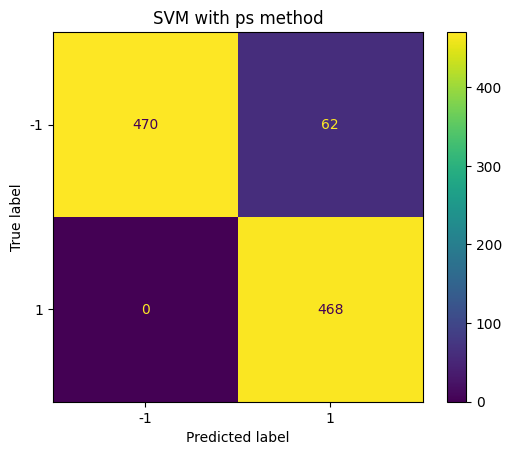

ACC = 0.938, F1 = 0.9378757515030061, PPV = 0.8830188679245283, NPV = 1.0, TPR = 1.0, TNR = 0.8834586466165414, FPR = 0.11654135338345864, FNR = 0.0

TP = 468, FP = 62, TN = 470, FN = 0


In [20]:
metricsPSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [21]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictorTopological/PS_SVM_safe.sav']

In [24]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ['x','y',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ['x','y',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ['x','y',"y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [25]:
model = model.FPcontrol(Xcal, Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([ 1.53751795e-05,  5.00012163e-01,  4.70027443e-06, ...,
         2.44375993e-02, -1.61108163e-06,  8.18330832e-03]),
 'b': array([-0.00040652]),
 'b_eps': 0.9664748294901703,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

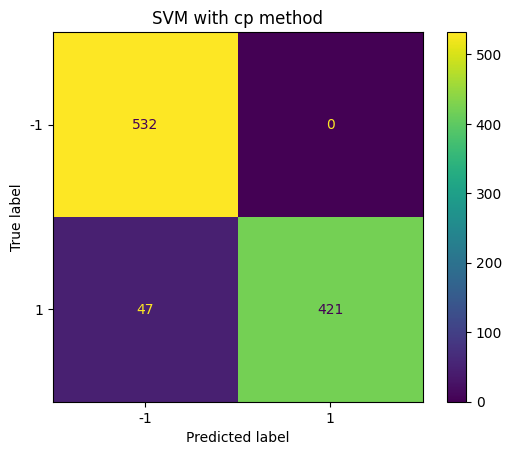

ACC = 0.953, F1 = 0.9471316085489314, PPV = 1.0, NPV = 0.918825561312608, TPR = 0.8995726495726496, TNR = 1.0, FPR = 0.0, FNR = 0.10042735042735043

TP = 421, FP = 0, TN = 532, FN = 47


In [26]:
metricsCSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [27]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictorTopological/CP_SVM_safe.sav']

In [28]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ['x','y',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ['x','y',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ['x','y',"y_true","y_conformal"])t
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)